In [2]:
using QuantumOptics
import PhysicalConstants.CODATA2018: c_0
using Unitful
using PyPlot
using LinearAlgebra
using CollectiveSpins

### Parameters

In [3]:
# Nbr of particles
N = 2

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Position of atoms
a = 1e-6 # Distance between atoms
r0 = [[0, 0, 0], [a, 0, 0]]

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
r0 = r0 / λ
Ω = Ω / γ

# Integration parameter
tstep = 0.1
T = [0:tstep:10;]; # Normalised time

### Parametrisation

In [4]:
# Basis
b1 = SpinBasis(1//2)
bmb = tensor([b1 for i = 1:N]...)

# One body operators
σp = sigmap(b1)
σm = sigmam(b1)
nup = σp*σm
ndown = σm*σp

# Many body operators
Jz = sum([embed(bmb, i, -8*ndown) for i = 1:N]) + sum([embed(bmb, i, -9*nup) for i = 1:N]) # 2 level system but GS has mJ = -8, ES has mJ = -9
Nup = sum([embed(bmb, i, nup) for i = 1:N]);

### Hamiltonians

In [5]:
HRO = -Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]));

In [6]:
J = [embed(bmb, i, σm) for i = 1:N];

# Spontaneous emission no $H$

In [7]:
# Initial state
Ψ0_mb = tensor([spinup(b1) for i = 1:N]...)
Γ = Matrix(I, N, N) # Normalized Γ

# Time evolution
ρt_se = timeevolution.master(T, Ψ0_mb, sparse(one(bmb)), J; rates=Γ, dt=tstep)[2];

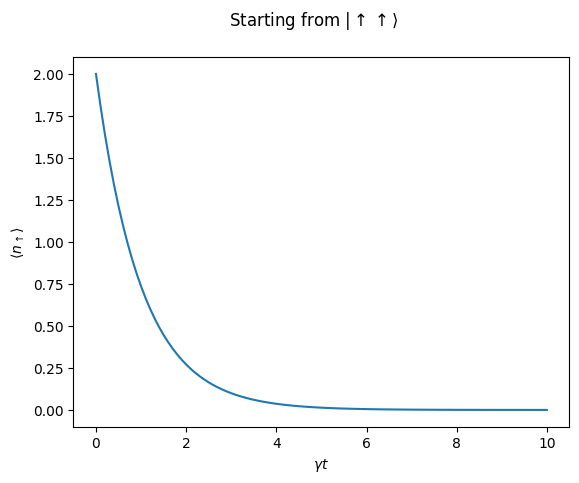

In [8]:
figure()
plot(T, real(expect(Nup, ρt_se)))
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\uparrow \uparrow \rangle $")
pygui(false); gcf()
#pygui(true); show()

# Without interactions

In [9]:
# Initial state
Ψ0_mb = tensor([spindown(b1) for i = 1:N]...)

# Time evolution
Γ = 1. * Matrix(I, N, N) # Normalized Γ
ρt_indep = timeevolution.master(T, Ψ0_mb, HRO, J; rates=Γ, dt=tstep)[2];

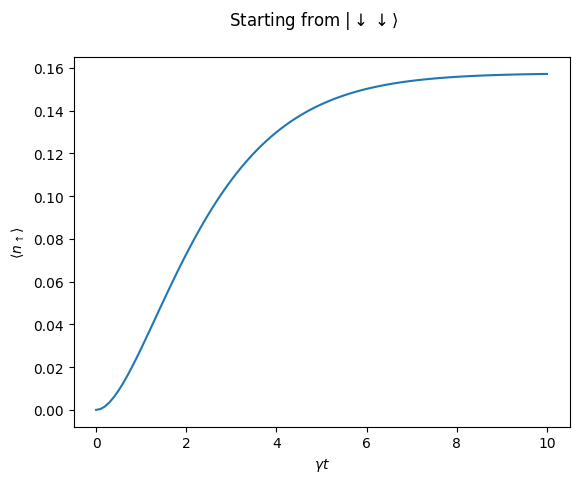

In [10]:
figure()
plot(T, real(expect(Nup, ρt_indep)))
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
pygui(false); gcf()
#pygui(true); show()

# Without interactions, varying $\Omega$

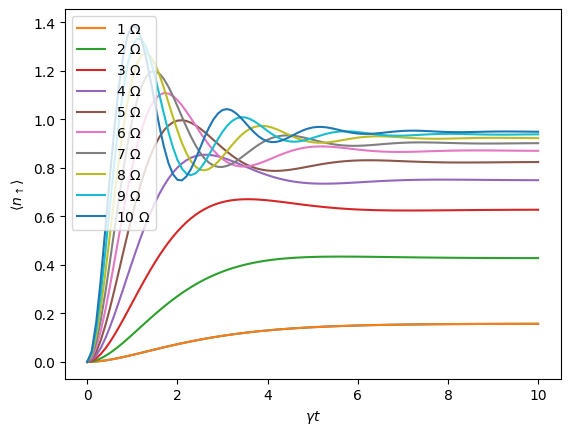

In [11]:
figure()
plot(T, real(expect(Nup, ρt_indep)))
for i in range(1, 10)
    HRO_var = -i*Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]))
    ρt_indep_var_Ω = timeevolution.master(T, Ψ0_mb, HRO_var, J; rates=Γ, dt=tstep)[2]
    plot(T, real(expect(Nup, ρt_indep_var_Ω)), label=string(i)*L" $\Omega$")
end
legend()
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
pygui(false); gcf()

# With electric interactions

In [12]:
# Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
e = [0, 0, 1.] # Quantization axis along z
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = interaction.OmegaMatrix(system)
Γ_CS = interaction.GammaMatrix(system);

H_elec = sum([sum([Ω_CS[i, j]*embed(bmb, i, σp)*embed(bmb, j, σm) for j = 1:N if i≠j]) for i = 1:N]);

In [13]:
# Initial state
Ψ0_mb = tensor([spindown(b1) for i = 1:N]...)

# Time evolution
Γ = 1. * Matrix(I, N, N) # Normalized Γ
ρt_elec = timeevolution.master(T, Ψ0_mb, HRO + H_elec, J; rates=Γ_CS, dt=tstep)[2];

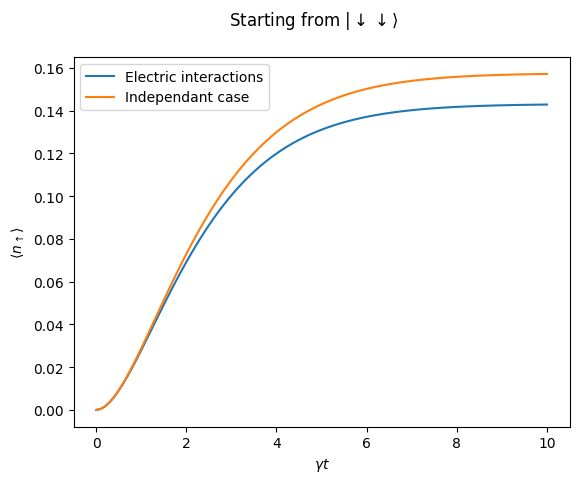

In [14]:
figure()
plot(T, real(expect(Nup, ρt_elec)), label="Electric interactions")
plot(T, real(expect(Nup, ρt_indep)), label="Independant case")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
#pygui(true); show()

# With electric interactions, varying $\Omega$

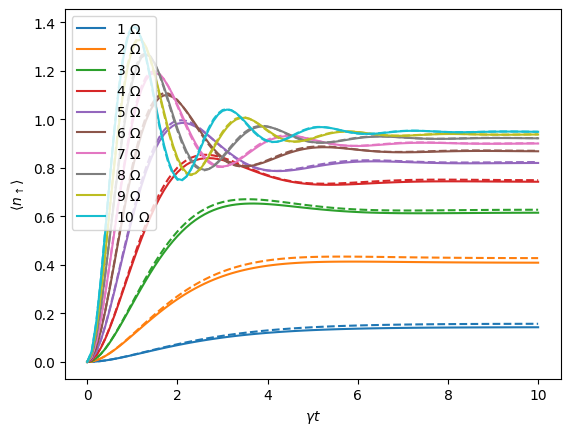

In [15]:
close("all")
figure()
for i in range(1, 10)
    HRO_var = -i*Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]))
    ρt_elec_var_Ω = timeevolution.master(T, Ψ0_mb, HRO_var + H_elec, J; rates=Γ_CS, dt=tstep)[2]
    line, = plot(T, real(expect(Nup, ρt_elec_var_Ω)), label=string(i)*L" $\Omega$")

    # Without interactions
    ρt_indep_var_Ω = timeevolution.master(T, Ψ0_mb, HRO_var, J; rates=Γ, dt=tstep)[2]
    plot(T, real(expect(Nup, ρt_indep_var_Ω)), color = line.get_color(), linestyle="--")
end
legend()
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
pygui(false); gcf()
#pygui(true); show()

# Brouillons

In [16]:
# deg = 1
# E0 = 1
# Ω = deg*E0/ustrip(ħ) 
# H0 = -Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)embed(bmb, i, σm) for i = 1:N])) + ustrip(ħ)*ω0/2*Jz

# Physical constants
#ħ = 1.